# Example calculations with scalar quantities

## Objectives

To demonstrate basic calculations using scalar fields (e.g., SSH, T, S) from the state estimate including: time series of mean quantities, spatial patterns of mean quantities, spatial patterns of linear trends, and spatial patterns of linear trends over different time periods.

## Introduction

We will demonstrate global calculations with SSH (global mean sea level time series, mean dynamic topography, global mean sea level trend) and a regional calculation with THETA (The Nino 3.4 index).

## Global calculations with SSH

First, load daily and monthly-mean SSH and THETA fields and the model grid parameters.

In [1]:
import numpy as np
import sys
import xarray as xr
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Import the ecco_v4_py library into Python
## =========================================

## -- If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  For example, if your ecco_v4_py
##    files are in /Users/ifenty/ECCOv4-py/ecco_v4_py, then use:

sys.path.append('/home/ifenty/ECCOv4-py')
import ecco_v4_py as ecco

In [3]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================
# base_dir = '/home/username/'
base_dir = '/home/ifenty/ECCOv4-release'

## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/Release3_alt'

Now load daily and monthly mean versions of SSH and THETA

In [4]:
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'

ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])

In [5]:
## Load 2D DAILY data, SSH, SST, and SSS 
data_dir= ECCO_dir + '/nctiles_daily'

ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['SSH','THETA'],\
                                           years_to_load=range(1993,2018)).load()
                                           
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_daily_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  SSH
loading files of  THETA


In [6]:
## Load 2D MONTHLY data, SSH, SST, and SSS 
data_dir= ECCO_dir + '/nctiles_monthly'

ecco_monthly_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['SSH','THETA'],\
                                           years_to_load=range(1993,2018), k_subset=[0]).load()
                                           
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_monthly_vars))

loading files of  THETA
loading files of  SSH


In [7]:
print(ecco_daily_ds.time[0].values)
print(ecco_daily_ds.time[-1].values)

print(ecco_monthly_ds.time[0].values)
print(ecco_monthly_ds.time[-1].values)

1993-01-01T12:00:00.000000000
2015-12-31T12:00:00.000000000
1993-01-16T12:00:00.000000000
2015-12-16T12:00:00.000000000


## Sea surface height

### Global mean sea level

Global mean sea surface height at time $t$ is defined as follows:

$$SSH_{\text{global mean}}(t) = \frac{\sum_{i} SSH(i,t) \,\, A(i)}{A_{\text{global ocean}}}$$

$$A_{\text{global ocean}} = \sum_{i} A(i)$$

Where $SSH(i,t)$ is dynamic height at model grid cell $i$ and time $t$, $A(i)$ is the area (m^2) of model grid cell $i$

There are several ways of doing the above calculations.  Since this is the first tutorial with actual calcuations, we'll present a few different approaches for getting to the same answer.

#### Part 1: $A_{\text{global ocean}}$

Let's start on the simplest quantity, the global ocean surface area $A_{\text{global ocean}}$.  Our calculation uses *SSH* which is a 'c' point variable.  The surface area of tracer grid cells is provided by the model grid parameter *rA*.  *rA* is a two-dimensional field that is defined over all model grid points, including land.  

To calculate the total ocean surface area we need to ignore the area contributions from land. 

We will first construct a 3D mask that is True for model grid cells that are wet and False for model grid cells that are dry cells.  

In [8]:
# ocean_mask is ceiling of hFacC which is 0 for 100% dry cells and
# 0 > hFacC >= 1 for grid cells that are at least partially wet

# hFacC is the fraction of the thickness (h) of the grid cell which
# is wet.  we'll consider all hFacC > 0 as being a wet grid cell
# and so we use the 'ceiling' function to make all values > 0 equal to 1.

ocean_mask = np.ceil(ecco_monthly_ds.hFacC)
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

In [9]:
# the resulting ocean_mask variable is a 2D DataArray because we only loaded 1 vertical level of the model grid
print(type(ocean_mask))
print((ocean_mask.dims))

<class 'xarray.core.dataarray.DataArray'>
('k', 'tile', 'j', 'i')


<Figure size 1080x450 with 0 Axes>

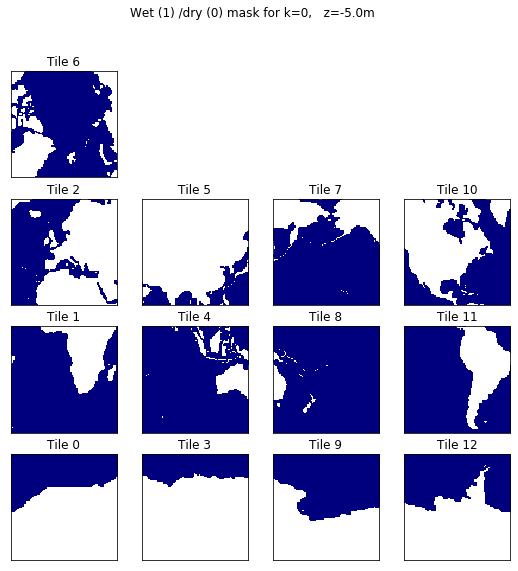

In [10]:
plt.figure(figsize=(12,5), dpi= 90)

ecco.plot_tiles(ocean_mask.isel(k=0),layout='latlon', rotate_to_latlon=True)

# select out the model depth at k=1, round the number and convert to string.
z = str((np.round(ecco_monthly_ds.Z.values[0])))
plt.suptitle('Wet (1) /dry (0) mask for k=' + str(0) + ',   z=' + z + 'm');

To calculate $A_{\text{global ocean}}$ we must apply the surface wet/dry mask to $rA$.  

In [11]:
# Method 1: the array index method, []
#           select land_c at k index 0
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask[0,:])

# these three methods give the same numerical result.  Here are 
# three alternative ways of printing the result
print ('total ocean surface area ( m^2) %d  ' % total_ocean_area.values)
print ('total ocean surface area (km^2) %d ' % (total_ocean_area.values/1.0e6))

# or in scientific notation with 2 decimal points
print ('total ocean surface area (km^2) %.2E' % (total_ocean_area.values/1.0e6))

total ocean surface area ( m^2) 358013844062208  
total ocean surface area (km^2) 358013844 
total ocean surface area (km^2) 3.58E+08


This compares favorable with *Global surface area of Earth's Oceans : approx 3.60 x $10^8$ $km^2$* from https://hypertextbook.com/facts/1997/EricCheng.shtml

##### Multiplication of DataArrays
You probably noticed that the multiplication of grid cell area with the land mask was done element by element.  One useful feature of `DataArrays` is that their dimensions are automatically lined up when doing binary operations.  Also, because *rA* and *ocean_mask* are both `DataArrays`, their inner product and their sums are also `DataArrays`.  

> Note:: *ocean_mask* has a depth (**k**) dimension while *rA* does not (horizontal model grid cell area does not change as a function of depth in ECCOv4).  As a result, when *rA* is multiplied with *ocean_mask* `xarray` **broadcasts** *rA* to all **k** levels.  The resulting matrix  inherits the **k** dimension from *ocean_mask*.

##### Another way of summing over `numpy` arrays

As *rA* and ocean both store `numpy` arrays, you can also calculate the sum of their product by invoking the `.sum()` command inherited in all `numpy arrays`:

In [12]:
total_ocean_area = (ecco_monthly_ds.rA*ocean_mask).isel(k=0).sum()
print ('total ocean surface area (km^2) ' + '%.2E' % (total_ocean_area.values/1e6))

total ocean surface area (km^2) 3.58E+08


#### Part2 : $SSH_{\text{global mean}}(t)$

The global mean *SSH* at each $t$ is given by,

$$SSH_{\text{global mean}}(t) = \frac{\sum_{i} SSH(i,t) \,\, A(i)}{A_{\text{global ocean}}}$$

One way of calculating this is to take advantage of `DataArray` coordinate labels and use its *.sum()* functionality to explicitly specify which dimensions to sum over:

In [13]:
# note no need to multiple RAC by land_c because SSH is nan over land
SSH_global_mean_mon = (ecco_monthly_ds.SSH*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area

In [14]:
# remove time mean from time series
SSH_global_mean_mon = SSH_global_mean_mon-SSH_global_mean_mon.mean(dim='time')

In [15]:
# add helpful unit label
SSH_global_mean_mon.attrs['units']='m'

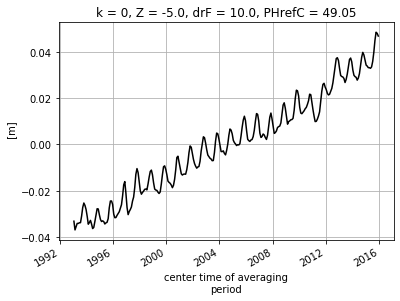

In [16]:
# and plot for fun
SSH_global_mean_mon.plot(color='k');plt.grid()

Alternatively we can do the summation over the three non-time dimensions.  The time dimension of SSH is along the first dimension (axis) of the array, axis 0.

In [17]:
# note no need to multiple RAC by land_c because SSH is nan over land
SSH_global_mean = np.sum(ecco_monthly_ds.SSH*ecco_monthly_ds.rA,axis=(1,2,3))/total_ocean_area
SSH_global_mean = SSH_global_mean.compute()

Even though *SSH* has 3 dimensions (time, tile, j, i) and *rA* and *ocean_mask.isel(k=0)* have 2 (j,i), we can mulitply them. With `xarray` the element-by-element multiplication occurs over their common dimension.

The resulting $SSH_{global-mean}$ `DataArray` has a single dimension, time.

#### Part 3 : Plotting the global mean sea level time series:

Before we plot the global mean sea level curve let's remove its time-mean to make it global mean sea level anomaly (the absolute value has no meaning here anyway).

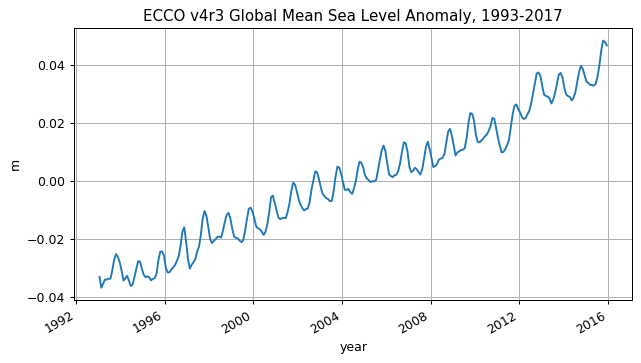

In [18]:
plt.figure(figsize=(8,4), dpi= 90)

# Method 1: .mean() method of `DataArrays`
SSH_global_mean_anomaly = SSH_global_mean - SSH_global_mean.mean()

# Method 2: numpy's `mean` method 
SSH_global_mean_anomaly = SSH_global_mean - np.mean(SSH_global_mean)

SSH_global_mean_anomaly.plot()
plt.grid()
plt.title('ECCO v4r3 Global Mean Sea Level Anomaly, 1993-2017');
plt.ylabel('m');
plt.xlabel('year');

### Mean Dynamic Topography

Mean dynamic topography is calculated as follows,

$MDT(i) = \frac{\sum_{t} SSH(i,t) - SSH_{\text{global mean}}(t)}{nt} $

Where $nt$ is the number of time records. 

For *MDT* we presere the spatial dimensions. Summation and averaging are over the time dimensions (axis 0).

In [19]:
## Two equivalent methods

# Method 1, specify the axis over which to average
MDT = np.mean(ecco_monthly_ds.SSH - SSH_global_mean,axis=0)

# Method 2, specify the coordinate label over which to average
MDT_B = (ecco_monthly_ds.SSH - SSH_global_mean).mean(dim=['time'])

# which can be verified using the '.equals()' method to compare Datasets and DataArrays
print(MDT.equals(MDT_B))

True


As expected, MDT has preserved its spatial dimensions:

In [20]:
MDT.dims

('tile', 'j', 'i')

Before plotting the MDT field remove its spatial mean since its spatial mean conveys no dynamically useful information.  

In [21]:
MDT_no_spatial_mean = MDT - MDT*ecco_monthly_ds.rA/total_ocean_area

In [22]:
MDT_no_spatial_mean.shape

(13, 90, 90)

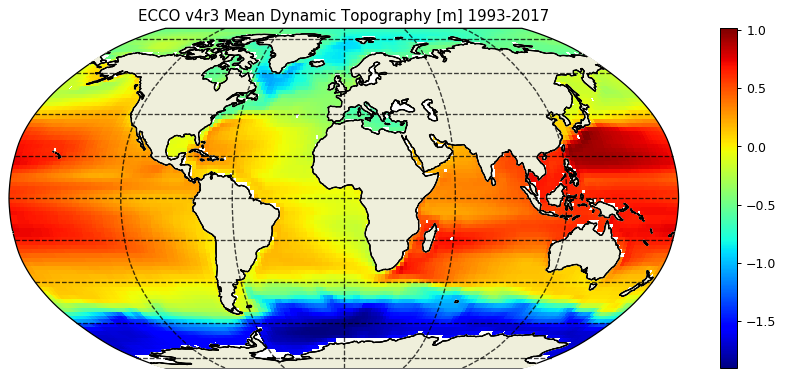

In [23]:
plt.figure(figsize=(12,5), dpi= 90)

# mask land points to Nan
MDT_no_spatial_mean = MDT_no_spatial_mean.where(ocean_mask[0,:] !=0)

ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, \
                              ecco_monthly_ds.YC, \
                              MDT_no_spatial_mean*ocean_mask, \
                              user_lon_0=0,\
                              plot_type = 'pcolormesh', \
                              show_colorbar=True,\
                              dx=2,dy=2);

plt.title('ECCO v4r3 Mean Dynamic Topography [m] 1993-2017');

### Spatial variations of sea level linear trends  

To calculate the linear trend for the each model point we will use on the `polyfit` function of `numpy`.  First, define a time variable in years for SSH.

In [24]:
days_since_first_record = ((ecco_monthly_ds.time - ecco_monthly_ds.time[0])/(86400e9)).astype(int).values
len(days_since_first_record)

276

Next, reshape the four dimensional SSH field into two dimensions, time and space (t, i)

In [25]:
ssh_flat = np.reshape(ecco_monthly_ds.SSH.values, (len(ecco_monthly_ds.SSH.time), 13*90*90))
ssh_flat.shape

(276, 105300)

Now set all $SSH$ values that are 'nan' to zero because the polynominal fitting
routine can't handle nans,

In [26]:
ssh_flat[np.nonzero(np.isnan(ssh_flat))] = 0
ssh_flat.shape

(276, 105300)

Do the polynomial fitting, https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyfit.html

In [27]:
# slope is in m / day
ssh_slope, ssh_intercept = np.polyfit(days_since_first_record, ssh_flat, 1)

print(ssh_slope.shape)

# and reshape the slope result back to 13x90x90    
ssh_slope = np.reshape(ssh_slope, (13, 90,90))

# mask 
ssh_slope_masked = np.where(ocean_mask[0,:] > 0, ssh_slope, np.nan)

# convert from m / day to mm/year
ssh_slope_mm_year = ssh_slope_masked*365*1e3

(105300,)


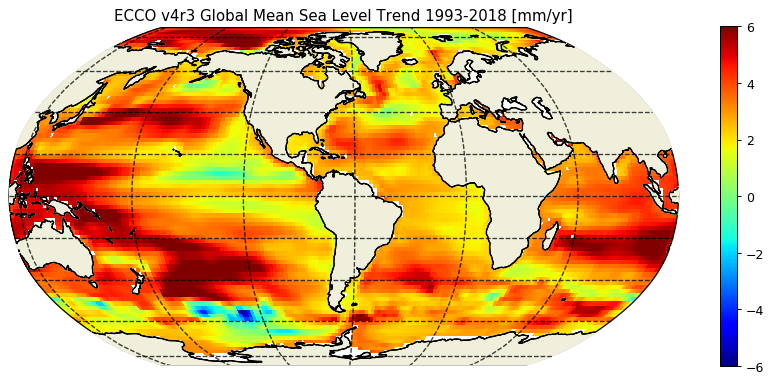

In [28]:
plt.figure(figsize=(12,5), dpi= 90)

ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, \
                              ecco_monthly_ds.YC, \
                              ssh_slope_mm_year, \
                              user_lon_0=-66,\
                              plot_type = 'pcolormesh', \
                              show_colorbar=True,\
                              dx=2,dy=2, cmin=-6, cmax=6)

plt.title('ECCO v4r3 Global Mean Sea Level Trend 1993-2018 [mm/yr]');

And the mean rate of global sea level change in mm/year over the 1993-2018 period is:

In [29]:
((ssh_slope_mm_year*ecco_monthly_ds.rA)/(ecco_monthly_ds.rA*ocean_mask).sum()).sum()

<xarray.DataArray ()>
array(3.18565693)

## Constructing Monthly means from Daily means

We can also construct our own monthly means from the daily means using this command:
(See http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html for more information)

In [30]:
# note no need to multiple RAC by land_c because SSH is nan over land
SSH_global_mean_day = (ecco_daily_ds.SSH*ecco_daily_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area

In [31]:
# remove time mean from time series
SSH_global_mean_day = SSH_global_mean_day-SSH_global_mean_day.mean(dim='time')

In [32]:
# add helpful unit label
SSH_global_mean_day.attrs['units']='m'

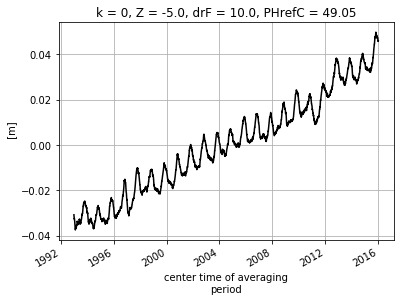

In [33]:
# and plot for fun
SSH_global_mean_day.plot(color='k');plt.grid()

In [34]:
SSH_global_mean_mon_alt = SSH_global_mean_day.resample(time='1M', loffset='-15D').mean()

Plot to compare.

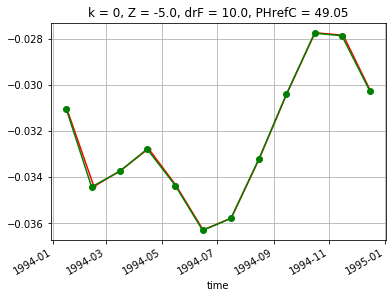

In [35]:
SSH_global_mean_mon.sel(time='1994').plot(color='r', marker='.');
SSH_global_mean_mon_alt.sel(time='1994').plot(color='g', marker='o');
plt.grid()

These small differences are simply an artifact of the time indexing.  We used loffset='15D' to shift the time of the monthly mean SSH back 15 days, close to the center of the month.  The SSH_global_mean_mon field is centered exactly at the middle of the month, and since months aren't exactly 30 days long, this results in a small discrepancy when plotting with a time x-axis.  If we plot without a time object x axis we find the values to be the same.  That's because ECCO monthly means are calculated over calendar months.

In [36]:
print ('date in middle of month')
print(SSH_global_mean_mon.time.values[0:2])
print ('\ndate with 15 day offset from the end of the month')
print(SSH_global_mean_mon_alt.time.values[0:2])

date in middle of month
['1993-01-16T12:00:00.000000000' '1993-02-15T12:00:00.000000000']

date with 15 day offset from the end of the month
['1993-01-16T00:00:00.000000000' '1993-02-13T00:00:00.000000000']


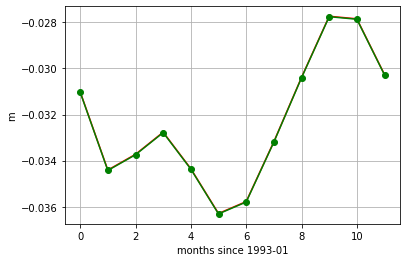

In [37]:
plt.plot(SSH_global_mean_mon.sel(time='1994').values, color='r', marker='.');
plt.plot(SSH_global_mean_mon_alt.sel(time='1994').values, color='g', marker='o');
plt.xlabel('months since 1993-01');
plt.ylabel('m')
plt.grid()

## Regional calculations with THETA

In [38]:
lat_bounds = np.logical_and(ecco_monthly_ds.YC >= -5, ecco_monthly_ds.YC <= 5)
lon_bounds = np.logical_and(ecco_monthly_ds.XC >= -170, ecco_monthly_ds.XC <= -120)

SST = ecco_monthly_ds.THETA.isel(k=0)
SST_masked=SST.where(np.logical_and(lat_bounds, lon_bounds))

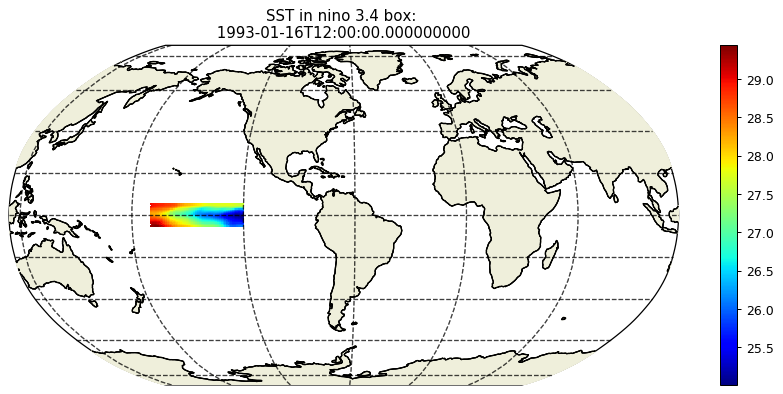

In [39]:
plt.figure(figsize=(12,5), dpi= 90)

ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, \
                              ecco_monthly_ds.YC, \
                              SST_masked.isel(time=0),\
                              user_lon_0 = -66,\
                              show_colorbar=True);

plt.title('SST in nino 3.4 box: \n %s ' % str(ecco_monthly_ds.time[0].values));

In [40]:
# Create the same mask for the grid cell area
rA_masked=ecco_monthly_ds.rA.where(np.logical_and(lat_bounds, lon_bounds));

# Calculate the area-weighted mean in the box
SST_masked_mean=(SST_masked*rA_masked).sum(dim=['tile','j','i'])/np.sum(rA_masked)

# Substract the temporal mean from the area-weighted mean to get a time series, the Nino 3.4 index
SST_nino_34_anom_ECCO_monthly_mean = SST_masked_mean - np.mean(SST_masked_mean)

### Load up the Nino 3.4 index values from ESRL

In [41]:
# https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/
# https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Data/nino34.long.anom.data
# NINA34
# 5N-5S 170W-120W 
# HadISST 
#  Anomaly from 1981-2010
#  units=degC

import urllib.request
data = urllib.request.urlopen('https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Data/nino34.long.anom.data')

# the following code parses the ESRL text file and puts monthly-mean nino 3.4 values into an array
start_year = 1993
end_year = 2015
num_years = end_year-start_year+1
nino34_noaa = np.zeros((num_years, 12))
for i,l in enumerate(data):
    line_str = str(l, "utf-8")
    x=line_str.split()
    try:
        year = int(x[0])
        row_i = year-start_year
        if row_i >= 0 and year <= end_year:
            
            print('loading nino 3.4 for year %s  row %s' % (year, row_i))

            for m in range(0,12):
                nino34_noaa[row_i, m] = float(x[m+1])
    except:
        continue


loading nino 3.4 for year 1993  row 0
loading nino 3.4 for year 1994  row 1
loading nino 3.4 for year 1995  row 2
loading nino 3.4 for year 1996  row 3
loading nino 3.4 for year 1997  row 4
loading nino 3.4 for year 1998  row 5
loading nino 3.4 for year 1999  row 6
loading nino 3.4 for year 2000  row 7
loading nino 3.4 for year 2001  row 8
loading nino 3.4 for year 2002  row 9
loading nino 3.4 for year 2003  row 10
loading nino 3.4 for year 2004  row 11
loading nino 3.4 for year 2005  row 12
loading nino 3.4 for year 2006  row 13
loading nino 3.4 for year 2007  row 14
loading nino 3.4 for year 2008  row 15
loading nino 3.4 for year 2009  row 16
loading nino 3.4 for year 2010  row 17
loading nino 3.4 for year 2011  row 18
loading nino 3.4 for year 2012  row 19
loading nino 3.4 for year 2013  row 20
loading nino 3.4 for year 2014  row 21
loading nino 3.4 for year 2015  row 22


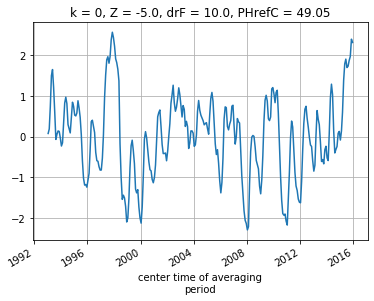

In [42]:
SST_nino_34_anom_ECCO_monthly_mean.plot();plt.grid()

we'll make a new DataArray for the NOAA SST nino_34 data by copying the DataArryay 
for the ECCO SST data and replacing the values

In [43]:
SST_nino_34_anom_NOAA_monthly_mean = SST_nino_34_anom_ECCO_monthly_mean.copy(deep=True)
SST_nino_34_anom_NOAA_monthly_mean.values[:] = nino34_noaa.ravel()

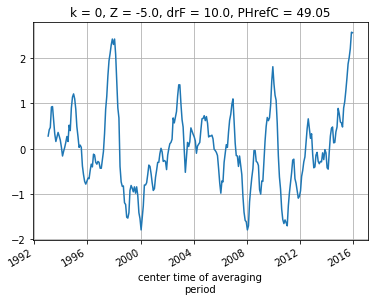

In [44]:
SST_nino_34_anom_NOAA_monthly_mean.plot();plt.grid()

### Plot the ECCOv4r3 and ESRL nino 3.4 index

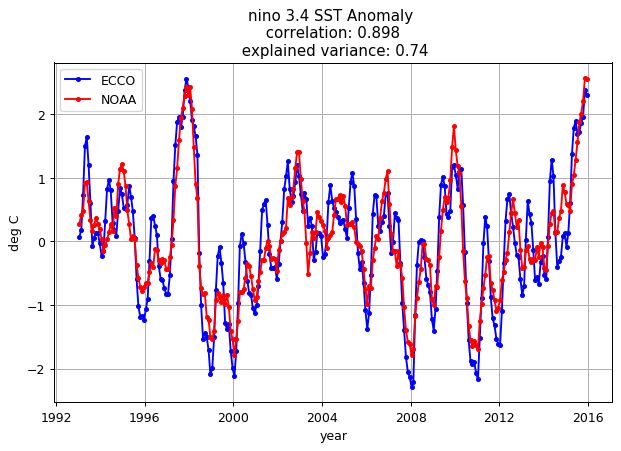

In [45]:
# calculate correlation between time series
nino_corr = np.corrcoef(SST_nino_34_anom_ECCO_monthly_mean, SST_nino_34_anom_NOAA_monthly_mean)[1]
nino_ev   = 1 - np.var(SST_nino_34_anom_ECCO_monthly_mean-SST_nino_34_anom_NOAA_monthly_mean)/np.var(SST_nino_34_anom_NOAA_monthly_mean)
plt.figure(figsize=(8,5), dpi= 90)
plt.plot(SST_nino_34_anom_ECCO_monthly_mean.time, \
             SST_nino_34_anom_ECCO_monthly_mean - SST_nino_34_anom_ECCO_monthly_mean.mean(),'b.-')
plt.plot(SST_nino_34_anom_NOAA_monthly_mean.time, \
             SST_nino_34_anom_NOAA_monthly_mean - SST_nino_34_anom_NOAA_monthly_mean.mean(),'r.-')
plt.title('nino 3.4 SST Anomaly \n correlation: %s \n explained variance: %s' % (np.round(nino_corr[0],3), \
                                                                                 np.round(nino_ev.values,3)));
plt.legend(('ECCO','NOAA'))
plt.ylabel('deg C');
plt.xlabel('year');
plt.grid()

ECCO is able to match the NOAA Nino 3.4 index faily well well.

## Conclusion

You should now be familiar with doing some doing calculations using scalar quantities.

### Suggested exercises

1. Create the SSH time series from 1992-2015
2. Create the global mean sea level trend (map) from 1992-2015
3. Create the global mean sea level trend (map) for two epochs 1992-2003, 2003-2015
4. Compare other nino indices
